# Jan 23, 2025: Find principal patterns of a community

GMM clustering, bootstraping

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist, cdist, correlation, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr, gaussian_kde, ranksums, wilcoxon, friedmanchisquare

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import NMF, PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [11]:
parcels_file = f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz'
# parcels_img = nib.load(parcels_file)

try:
    roi_table = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')
    roi_labels = roi_table['roi'].to_numpy()
except:
    roi_labels = np.arange(1, args.num_rois+1)

In [12]:
roi_table

,old_roi,name,roi
0,1,"R-Frontal pole, cerebral cortex (FRP,184)",1
1,2,"R-Primary motor area (MOp,985)",2
2,3,"R-Secondary motor area (MOs,993)",3
3,4,"R-Primary somatosensory area, nose (SSp-n,353)",4
4,5,"R-Primary somatosensory area, barrel field (SS...",5
...,...,...,...
167,168,"L-Medulla, sensory related (MY-sen,472)",168
168,169,"L-Medulla, motor related (MY-mot,456)",169
169,170,"L-Medulla, behavioral state related (MY-sat,465)",170
170,171,"L-Cerebellar cortex (CBX,614)",171


In [13]:
args.method = 'hierarchical'

In [14]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-{args.method}_desc-merged-pis.pkl', 'rb') as f:
    merged_pis_df = pickle.load(f)

In [15]:
merged_pis_df

,sub,sbm,omega,pi,sil
0,00,sbm-nd-h,0.500108,"[[0.041480992414467066, 0.004175084175084165, ...",k ...
1,00,sbm-nd-h,0.191246,"[[0.8747844827586208, 0.0, 0.1021551724137931,...",k ...
2,00,sbm-nd-h,0.142725,"[[0.8483659885452678, 0.0, 0.09019733848686834...",k ...
3,00,sbm-nd-h,0.132811,"[[0.8459903242342689, 0.008472375135437415, 0....",k ...
4,00,sbm-nd-h,0.031086,"[[0.45227272727272727, 0.0, 0.4727272727272727...",k ...
...,...,...,...,...,...
565,grp,sbm-nd-h,0.683759,"[[0.8959045802766508, 0.0, 0.04427912827014335...",k labels ...
566,grp,sbm-nd-h,0.152146,"[[0.8647741147741148, 0.019230769230769232, 0....",k labels ...
567,grp,sbm-nd-h,0.071034,"[[0.04225352112676056, 0.16901408450704225, 0....",k labels ...
568,grp,sbm-nd-h,0.057237,"[[0.23105590062111803, 0.14285714285714285, 0....",k labels ...


In [16]:
num_comms = merged_pis_df.at[0, 'pi'].shape[1]
num_comms

9

In [17]:
range_num_patterns = list(range(1, 10))
range_num_patterns

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [18]:
def collect_community_vectors(merged_pis_df, comm):
    community_vectors = np.stack(merged_pis_df['pi'].apply(lambda pi: pi[:, comm]).to_list())
    community_vectors = np.nan_to_num(community_vectors)
    community_vectors += 1e-10
    # community_vectors is of shape N_{total-super-modes} x N_{rois}
    return community_vectors

In [19]:
def fit_bootstrap_sample(b, X_data, param_grid):
    # Resample
    X_res = resample(X_data, replace=True, random_state=args.SEED + b)
    
    results = []
    for k in param_grid['n_components']:
        for cov in param_grid['covariance_type']:
            # Fit GMM
            try:
                gmm = GaussianMixture(
                    n_components=k, 
                    covariance_type=cov, 
                    random_state=args.SEED,
                    n_init=5, # Lower n_init for speed inside bootstrap
                ).fit(X_res)
                
                # Calculate BIC on the bootstrap sample
                bic = gmm.bic(X_res)
                
                results.append({
                    'boot_id': b,
                    'param_n_components': k,
                    'param_covariance_type': cov,
                    'bic_score': bic,
                })
            except:
                continue # Skip failures
    return results

In [20]:
def summarize_boots(boot_df:pd.DataFrame):
    def ci_lo(x): return np.percentile(x, 2.5)
    def ci_hi(x): return np.percentile(x, 97.5)
    
    summary_df = boot_df.groupby(['param_n_components', 'param_covariance_type'])['bic_score'].agg(
        mean_bic='mean',
        ci_lower=ci_lo,
        ci_upper=ci_hi
    ).reset_index()
    
    summary_df['95% CI'] = summary_df.apply(
        lambda x: f"[{x['ci_lower']:.2f}, {x['ci_upper']:.2f}]", axis=1
    )
    
    final_table = summary_df[[
        'param_n_components', 
        'param_covariance_type', 
        'mean_bic', 
        '95% CI',
    ]]
    
    final_table = final_table.sort_values(by=['mean_bic'])
    
    final_table.to_csv(f'{folder}/desc-model-selection-ci-table.csv', index=False)
    
    return None

In [21]:
def summarize_boot_stats(boot_stats: pd.DataFrame):
    # Create a detailed summary table
    summary_df = boot_stats.reset_index().copy()
    summary_df['se_bic'] = summary_df['std_bic']
    best_model_score = summary_df['mean_bic'].min()
    best_model_se = summary_df.loc[summary_df['mean_bic'].idxmin(), 'se_bic']
    
    # Calculate distance from the best model
    summary_df['delta_bic'] = summary_df['mean_bic'] - best_model_score
    # How many "standard errors" away is this model?
    summary_df['sigma_dist'] = summary_df['delta_bic'] / best_model_se
    
    # Sort for readability
    summary_df = summary_df.sort_values(by=['mean_bic'])
    
    # Save it
    summary_df.to_csv(f'{folder}/desc-model-selection-table.csv', index=False)
    
    return None

In [22]:
def select_optimal_model(boot_stats):
    """
    Selects the best model based on aggregated bootstrap statistics.
    boot_stats should have index (n_components, covariance_type) and cols (mean_bic, std_bic)
    """
    # Find the absolute best model (lowest BIC)
    best_idx = boot_stats['mean_bic'].idxmin()
    best_score = boot_stats.loc[best_idx, 'mean_bic']
    best_sem = boot_stats.loc[best_idx, 'std_bic'] # Using std of bootstrap distribution as SEM
    
    # 1-SE Rule: Threshold is Best + SEM
    cutoff = best_score + best_sem

    # Filter candidates within the cutoff
    candidates = boot_stats[boot_stats['mean_bic'] <= cutoff].copy().reset_index()
    
    # Parsimony logic
    cov_complexity = {
        'spherical': 1, 
        'diag': 2,      # O(K * D) parameters -> Efficient for high D
        'tied': 3,      # O(D^2) parameters   -> Expensive for high D
        'full': 4       # O(K * D^2) parameters
    }
    candidates['cov_rank'] = candidates['param_covariance_type'].map(cov_complexity)

    # Sort by complexity (k, then covariance type)
    winner = candidates.sort_values(by=['param_n_components', 'cov_rank']).iloc[0]

    best_k = winner['param_n_components']
    best_cov = winner['param_covariance_type']
    return best_k, best_cov

In [23]:
def clean_cluster_vectors(cluster_vecs, medioid, n_perms=100, alpha=0.05):
    n_samples = cluster_vecs.shape[0]
    valid_idxs = []
    
    for i in range(n_samples):
        sample_vec = cluster_vecs[i]
        
        # true similarity?
        true_r = euclidean(sample_vec, medioid)
        
        # null similarity?
        null_rs = []
        for _ in range(n_perms):
            shuffled_vec = np.random.permutation(sample_vec)
            null_r = euclidean(shuffled_vec, medioid)
            null_rs.append(null_r)
        
        null_rs = np.array(null_rs)
        
        # p-value?
        # H0: The random vector is as close or closer than the true vector.
        # P = Fraction of nulls that are smaller (better) than true_dist
        p_val = np.mean(null_rs <= true_r)
        if p_val < alpha:
            valid_idxs.append(i)
    
    if len(valid_idxs) == 0:
        return np.zeros((1, cluster_vecs.shape[1]))
       
    return cluster_vecs[valid_idxs]

In [24]:
def get_medioids(best_k, final_labels, best_gmm, community_vectors):
    medioid_vecs = []
    for i in range(best_k):
        cluster_idxs = np.where(final_labels == i)[0]
        
        cluster_data = community_vectors[cluster_idxs, :]
        centroid_vec = best_gmm.means_[i, :].reshape(1, -1)
        
        distances = cdist(cluster_data, centroid_vec, metric='euclidean')
        min_idx = cluster_idxs[np.argmin(distances)]
        medioid_vec = community_vectors[min_idx]
        
        # prune random vectors
        cluster_vecs = clean_cluster_vectors(cluster_data, medioid_vec)
        centroid_vec = np.mean(cluster_vecs, axis=0).reshape(1, -1)
        distances = cdist(cluster_vecs, centroid_vec, metric='euclidean')
        min_idx = np.argmin(distances)
        medioid_vec = cluster_vecs[min_idx]
        
        
        medioid_vecs.append(medioid_vec)
        
    return np.stack(medioid_vecs)

In [25]:
def plot_grid_search(boot_df: pd.DataFrame, comm: int):
    plot_df = boot_df
    # plot_df = plot_df[~plot_df['param_covariance_type'].isin(['full', 'tied', 'spherical'])] # Hide full if desired
    
    g = sns.catplot(
        data=plot_df, 
        kind='bar', 
        x='param_n_components', 
        y='bic_score', 
        hue='param_covariance_type',
        height=1.5, 
        aspect=2,
        errorbar='sd', # standard deviation of the bootstrap distribution
        palette=CUD_COLORS, 
        alpha=0.8, 
        legend_out=True,
    )
    
    sns.stripplot(
        data=plot_df,
        x='param_n_components',
        y='bic_score',
        hue='param_covariance_type',
        dodge=True,       # <--- CRITICAL: Aligns points with the hue-grouped bars
        jitter=True,     
        color='black',    
        size=1.0,           
        alpha=0.5,        
        legend=False,     
        ax=g.ax,
    )
    
    sns.move_legend(g, 'center right', bbox_to_anchor=(0.93, 0.5))
    g.despine()
    g.set(ylabel='BIC\n' + f'(lower is better)', xlabel=f'Number of patterns', title=f'Comm {comm+1:02d}')
    ymin, ymax = g.ax.get_ylim()
    # g.set(ylim=[ymin, 5])
    ymin = boot_df['bic_score'].min()
    ymax_all = boot_df['bic_score'].max()
    # Focus view on the "good" models (bottom 20% of range)
    view_range = ymax_all - ymin
    g.set(ylim=[ymin - view_range*0.05, ymin + view_range*0.3])
    g.legend.set(title=f'Covariance type')
    return g

In [26]:
def plot_medioid_vectors(medioid_vecs, comm):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 3))
    sns.heatmap(
        medioid_vecs.T, ax=ax, 
        cmap='Blues',
    )
    ax.set(
        ylabel='ROI', xlabel=f'Principal pattern', title=f'Comm {comm+1:02d}',
        xticks=np.arange(1, medioid_vecs.T.shape[1]+1, 2)-0.5, 
        xticklabels=range(1, medioid_vecs.T.shape[1]+1, 2),
    )
    return fig

In [27]:
def plot_prevalence(df_prev, best_gmm, comm):
    gen_scores = np.round((df_prev > 0).mean() * 100, decimals=0)
    
    df_plot = df_prev.reset_index().melt(
        id_vars='sample_id',
        var_name='pattern',
        value_name='prevalence',
    )

    ndists = best_gmm.n_components
    fig, ax = plt.subplots(1, 1, figsize=(0.75*ndists, 1))

    sns.violinplot(
        data=df_plot, 
        x='pattern', y='prevalence', 
        ax=ax,
        split=True,
        inner=None,
        density_norm='count',
        color=CUD_COLORS[0],
        linecolor='grey',
        linewidth=0,
        saturation=1.0,
        alpha=0.3,
    )

    sns.boxplot(
        data=df_plot, 
        x='pattern', y='prevalence', 
        ax=ax, 
        color='grey',
        fill=False, 
        width=0.5, 
        linewidth=1,
        fliersize=0,
        capprops=dict(linewidth=0),
        zorder=2,
    )

    sns.stripplot(
        data=df_plot, 
        x='pattern', y='prevalence', 
        ax=ax,
        color=CUD_COLORS[0],
        size=2,
        marker='o',
        alpha=0.5, 
        jitter=True,
        zorder=1,
    )
    
    xticklabels = [
        f'{i+1:02d}\n' + f'({score:.0f}%)'
        for i, score in zip(range(ndists), gen_scores)
    ]

    sns.despine(ax=ax)
    ax.set(
        ylabel='Prevalence', xlabel=f'Principal pattern\n' + f'(Generalizability score)', 
        title=f'Comm {comm+1:02d}',
        xticklabels=xticklabels, yticks=[0, 0.5, 1],
    )
    ax.grid(alpha=0.15)
    return fig

In [28]:
def plot_eff_num_patterns(Ep_df, comm):
    fig, ax = plt.subplots(1, 1, figsize=(0.5, 1))

    sns.violinplot(
        data=Ep_df, 
        ax=ax,
        split=True,
        inner=None,
        density_norm='count',
        color=CUD_COLORS[0],
        linecolor='grey',
        linewidth=0,
        saturation=1.0,
        alpha=0.3,
    )

    sns.boxplot(
        data=Ep_df, 
        ax=ax, 
        color='grey',
        fill=False, 
        width=0.5, 
        linewidth=1,
        fliersize=0,
        capprops=dict(linewidth=0),
    )

    sns.stripplot(
        data=Ep_df, 
        ax=ax,
        color=CUD_COLORS[0],
        size=2,
        marker='o',
        alpha=0.5, 
        jitter=True,
    )

    ymin, ymax = np.percentile(Ep_df, q=[2.5, 97.5])
    sns.despine(ax=ax)
    ax.set(title=f'Comm {comm+1:02d}', ylim=[0.5, ymax], ylabel=f'Effective number\n' + f'of patterns')
    ax.grid(alpha=0.15)
    return fig

In [29]:
def get_roi_compositions(roi_vecs, generalizability_score, score_threshold=0.5, mem_threshold=0.2, ):
    valid_pattern_idxs = [i for i, score in enumerate(generalizability_score) if score > score_threshold]
    n_valid = len(valid_pattern_idxs)
    
    membership_vecs = roi_vecs[valid_pattern_idxs, :]
    present_rois = membership_vecs > mem_threshold
    count_present = np.sum(present_rois, axis=0)
    
    roi_types = []
    for count in count_present:
        if count == n_valid:
            roi_types.append('core')      # Present in ALL
        elif count == 0:
            roi_types.append('background') # Present in NONE
        else:
            roi_types.append('flexible')  # Present in SOME
            
    mean_weights = np.mean(membership_vecs, axis=0)
    
    rois_df = pd.DataFrame({
        'name': roi_table['name'],
        'type': roi_types,
        'frequency': count_present / len(valid_pattern_idxs),
        'mean_weight': np.round(mean_weights, decimals=3), # helps rank the core
    })
    
    for idx, roi_vec in enumerate(roi_vecs):
        rois_df[f'pattern_{idx+1:02d}'] = np.round(roi_vec, decimals=3)
    
    return rois_df

In [30]:
def analyze_dominance(df_prev: pd.DataFrame, gen_thresh=50):
    scores = (df_prev > 0).mean() * 100
    valid_patterns = scores[scores > gen_thresh].index
    df_valid = df_prev[valid_patterns]
    
    if len(valid_patterns) < 2:
        stat, p = -float('inf'), -float('inf')
    
    elif len(valid_patterns) == 2:
        stat, p = wilcoxon(df_valid.iloc[:, 0], df_valid.iloc[:, 1])
        
    else:
        stat, p = friedmanchisquare(*[df_valid[col] for col in valid_patterns])
    
    return stat, p

In [31]:
args.n_boot = 50

In [32]:
for comm in tqdm(range(num_comms)[1:2]):
    folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/gmm/comm-{comm}'
    os.makedirs(folder, exist_ok=True)
    
    community_vectors = collect_community_vectors(merged_pis_df, comm)
    community_vectors = normalize(community_vectors, norm='l2', axis=1)

    param_grid = {
        'n_components': range_num_patterns, 
        'covariance_type': ['spherical', 'tied', 'diag', 'full'],
    }
    boot_results_lists = Parallel(n_jobs=10)(
        delayed(fit_bootstrap_sample)(b, community_vectors, param_grid)
        for b in range(args.n_boot)
    )
    flat_results = [item for sublist in boot_results_lists for item in sublist]
    boot_df = pd.DataFrame(flat_results)
    boot_df['bic_score'] /= 10000
    
    boot_stats = boot_df.groupby(['param_n_components', 'param_covariance_type'])['bic_score'].agg(
        mean_bic='mean',
        std_bic='std', # this IS the standard error of the mean estimate
    )
    
    best_k, best_cov = select_optimal_model(boot_stats)
    
    best_gmm = GaussianMixture(
        n_components=best_k, 
        covariance_type=best_cov, 
        random_state=args.SEED, 
        n_init=10 # keep it high (> 1) to ensure convergence
    ).fit(community_vectors)
    final_labels = best_gmm.predict(community_vectors)
    
    with open(f'{folder}/desc-boot-df.pkl', 'wb') as f:
        pickle.dump(boot_df, f)
        
    boot_stats.to_csv(f'{folder}/desc-boot-stats.csv', sep=',')
    
    summarize_boot_stats(boot_stats)
    summarize_boots(boot_df)
        
    g = plot_grid_search(boot_df, comm)
    g.savefig(f'{folder}/desc-grid-search-plot.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/desc-grid-search-plot.png', transparent=True, dpi=300, bbox_inches='tight')
    
    medioid_vecs = get_medioids(best_k, final_labels, best_gmm, community_vectors)
    fig = plot_medioid_vectors(medioid_vecs, comm)
    fig.savefig(f'{folder}/desc-roi-vectors-plot.svg', transparent=True, dpi=300, bbox_inches='tight')
    fig.savefig(f'{folder}/desc-roi-vectors-plot.png', transparent=True, dpi=300, bbox_inches='tight')  
    
    with open(f'{folder}/desc-best-gmm.pkl', 'wb') as f:
        pickle.dump(best_gmm, f) 
    
    with open(f'{folder}/desc-best-gmm-means.pkl', 'wb') as f:
        pickle.dump(best_gmm.means_.T, f) 
        
    with open(f'{folder}/desc-best-gmm-medioids.pkl', 'wb') as f:
        pickle.dump(medioid_vecs.T, f) 
    
    
    # prevalence: are these patterns within each sample or between samples?
    sample_ids = merged_pis_df['sub'].to_list()

    df_prev = pd.DataFrame(dict(
        sample_id=sample_ids, 
        pattern_label=final_labels,
    ))

    df_prev = pd.crosstab(
        index=df_prev['sample_id'],
        columns=df_prev['pattern_label'],
        normalize='index',
    )

    generalizability_score = (df_prev > 0).mean()
    generalizability_score.to_csv(f'{folder}/desc-generalizability-scores.txt')
    # generalizable if found in >50% of bootstrap samples
    np.savetxt(f'{folder}/desc-generalizability-score-sum.txt', [np.sum(generalizability_score)])
    
    fig = plot_prevalence(df_prev, best_gmm, comm)
    fig.savefig(f'{folder}/desc-pattern-prevalence-plot.svg', transparent=True, dpi=300, bbox_inches='tight')
    fig.savefig(f'{folder}/desc-pattern-prevalence-plot.png', transparent=True, dpi=300, bbox_inches='tight')
    
    Ep_df = df_prev.apply(lambda x: np.exp(stats.entropy(x)), axis=1)
    fig = plot_eff_num_patterns(Ep_df, comm)
    fig.savefig(f'{folder}/desc-effective-number-of-patterns-plot.svg', transparent=True, dpi=300, bbox_inches='tight')
    fig.savefig(f'{folder}/desc-effective-number-of-patterns-plot.png', transparent=True, dpi=300, bbox_inches='tight')
    
    # roi compositions
    rois_df = get_roi_compositions(
        medioid_vecs, 
        generalizability_score, 
    )
    rois_df.to_csv(f'{folder}/desc-roi-compositions.csv', sep=',')
    
    # prevalence analyses
    stat, p = analyze_dominance(df_prev)
    np.savetxt(f'{folder}/desc-prevalence-analyses.txt', [stat, p])
    
plt.close('all')

100%|██████████| 1/1 [01:31<00:00, 91.42s/it]


In [39]:
merge_thresh = 0.15 # anything with r > 0.85
Z = linkage(medioid_vecs, method='average', metric='cosine')
num_orig = len(medioid_vecs)

if num_orig > 2:
    
    best_score = -1
    best_k_merged = num_orig
    best_labels = np.arange(num_orig)
    
    for k in range(2, num_orig):
        current_labels = fcluster(Z, t=k, criterion='maxclust') - 1
        try:
            score = silhouette_score(medioid_vecs, current_labels, metric='cosine')
        except ValueError:
            score = -1
        
        if score > best_score:
            best_score = score
            best_k_merged = k
            best_labels = current_labels
    
    if best_score > 0.1:
        merged_ids = best_labels
        num_merged = best_k_merged
    else:
        merged_ids = np.arange(num_orig)
        num_merged = num_orig
        
    label_map = {old_idx: new_idx for old_idx, new_idx in enumerate(merged_ids)}
    new_final_labels = np.array([label_map[l] for l in final_labels])            

In [40]:
merged_ids

array([2, 1, 1, 0, 1, 1, 0], dtype=int32)

In [41]:
label_map

{0: np.int32(2),
 1: np.int32(1),
 2: np.int32(1),
 3: np.int32(0),
 4: np.int32(1),
 5: np.int32(1),
 6: np.int32(0)}

In [36]:
generalizability_score

pattern_label
0    0.198895
1    0.270718
2    0.486188
3    0.270718
4    0.337017
5    0.397790
6    0.176796
dtype: float64

In [37]:
community_vectors

array([[8.30844289e-04, 1.92612832e-01, 1.88121021e-01, ...,
        1.99000603e-11, 1.99000603e-11, 1.99000603e-11],
       [2.16488063e-11, 1.86409591e-01, 4.00766772e-03, ...,
        2.16488063e-11, 2.16488063e-11, 2.16488063e-11],
       [2.02169875e-11, 1.95648267e-01, 2.26107888e-02, ...,
        2.02169875e-11, 2.02169875e-11, 2.02169875e-11],
       ...,
       [3.83436895e-02, 1.74331774e-01, 1.68451208e-01, ...,
        2.26866829e-11, 2.26866829e-11, 2.26866829e-11],
       [3.23373045e-02, 1.90950779e-01, 8.34442180e-02, ...,
        2.26361131e-11, 2.26361131e-11, 2.26361131e-11],
       [2.02134815e-11, 2.02134815e-01, 2.02134815e-11, ...,
        2.02134815e-11, 2.02134815e-11, 2.02134815e-11]], shape=(570, 172))

In [38]:
community_vectors_norm = normalize(community_vectors, norm='l2', axis=1)

In [47]:
def get_stability_curve(community_vectors, sample_ids, k_range=range(1, 7)):
    stability_scores = []
    
    for k in k_range:
        gmm = GaussianMixture(
            n_components=k, 
            covariance_type='diag', 
            n_init=5, 
            random_state=args.SEED
        )
        labels = gmm.fit_predict(community_vectors)
        
        df_prev = pd.DataFrame({
            'sample_id': sample_ids, 
            'label': labels,
        })
        xtab = pd.crosstab(
            df_prev['sample_id'], 
            df_prev['label'], 
            normalize='index'
        )
        
        gen_scores = (xtab > 0).mean()
        avg_stability = gen_scores.mean()
        
        stability_scores.append({
            'k': k,
            'stability': avg_stability, 
            'scores': gen_scores.values,
        })
    
    return pd.DataFrame(stability_scores)

In [52]:
def boot_stability_analysis(community_vectors, sample_ids, k_range=range(1, 7), n_boot=100):
    boot_stats = []
    unique_ids = np.unique(sample_ids)
    
    for b in tqdm(range(n_boot)):
        resampled_ids = resample(unique_ids, replace=True, random_state=+b)
        
        indices = []
        new_sample_ids = []
        id_to_idx = {
            uid: np.where(np.array(sample_ids) == uid)[0]
            for uid in unique_ids
        }
        for uid in resampled_ids:
            idxs = id_to_idx[uid]
            indices.extend(idxs)
            new_sample_ids.extend([uid]*len(idxs))
        
        X_boot = community_vectors[indices]
        
        df_curve = get_stability_curve(X_boot, new_sample_ids, k_range)
        
        for _, row in df_curve.iterrows():
            boot_stats.append({
                'boot_id': b,
                'k': row['k'], 
                'stability': row['stability'],
            })
    
    df_boot = pd.DataFrame(boot_stats)
    
    summary = df_boot.groupby('k')['stability'].agg(
        mean_stability='mean',
        ci_lower=lambda x: np.percentile(x, 2.5),
        ci_upper=lambda x: np.percentile(x, 97.5),
    ).reset_index()
    
    return summary, df_boot

In [55]:
summary, df_boot = boot_stability_analysis(
    community_vectors, 
    sample_ids, 
    range(1, 10), 
    100,
)

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


In [57]:
summary.to_csv('summary.csv')

In [58]:
summary

,k,mean_stability,ci_lower,ci_upper
0,1,1.000000,1.000000,1.000000
1,2,0.721463,0.684685,0.783263
2,3,0.551695,0.519377,0.582032
3,4,0.463033,0.432715,0.486428
4,5,0.392602,0.367476,0.414596
5,6,0.339814,0.321072,0.357902
6,7,0.297395,0.275946,0.313956
7,8,0.265658,0.252775,0.280134
8,9,0.240797,0.225237,0.253222


In [59]:
df_boot

,boot_id,k,stability
0,0,1,1.000000
1,0,2,0.699153
2,0,3,0.564972
3,0,4,0.478814
4,0,5,0.393220
...,...,...,...
895,99,5,0.421429
896,99,6,0.354167
897,99,7,0.309949
898,99,8,0.275670


In [67]:
def plot_model_selection(df_boot, summary_df, comm):
    df_plot = df_boot.copy()
    
    ks = sorted(df_plot['k'].unique())
    ndists = len(ks)
    
    fig, ax = plt.subplots(1, 1, figsize=(0.75 * ndists, 2.0))
    
    # sns.violinplot(
    #     data=df_plot, 
    #     x='k', y='stability',
    #     ax=ax, 
    #     split=True,
    #     inner=None, 
    #     density_norm='count',
    #     color=CUD_COLORS[0],
    #     linecolor='grey',
    #     linewidth=0,
    #     saturation=1.0,
    #     alpha=0.3,
    # )
    
    sns.boxplot(
        data=df_plot, 
        x='k', y='stability', 
        ax=ax, 
        color='grey',
        fill=False, 
        width=0.5, 
        linewidth=1,
        fliersize=0,
        capprops=dict(linewidth=0),
        zorder=2,
    )
    
    sns.stripplot(
        data=df_plot, 
        x='k', y='stability', 
        ax=ax,
        color=CUD_COLORS[0],
        size=2,
        marker='o',
        alpha=0.5, 
        jitter=True,
        zorder=1,
    )
    
    xticklabels = []
    for k in ks:
        # Find mean for this k
        row = summary_df[summary_df['k'] == k]
        if not row.empty:
            mean_val = row['mean_stability'].values[0]
            label = f'K={k}\n({mean_val*100:.0f}%)'
        else:
            label = f'K={k}'
        xticklabels.append(label)
        
    sns.despine(ax=ax)
    ax.set(
        ylabel='Mean Stability\n(Prevalence)', 
        xlabel='Number of Patterns (K)', 
        title=f'Model Selection: Comm {comm+1:02d}',
        xticklabels=xticklabels, 
        ylim=[0, 1.1],       # Fix range 0-1
        yticks=[0, 0.5, 1],  # Clean ticks
    )
    
    ax.axhline(
        0.5, 
        color='grey', linestyle='--', linewidth=0.8, 
        alpha=0.5, zorder=0
    )
    ax.grid(alpha=0.15)
    
    return fig

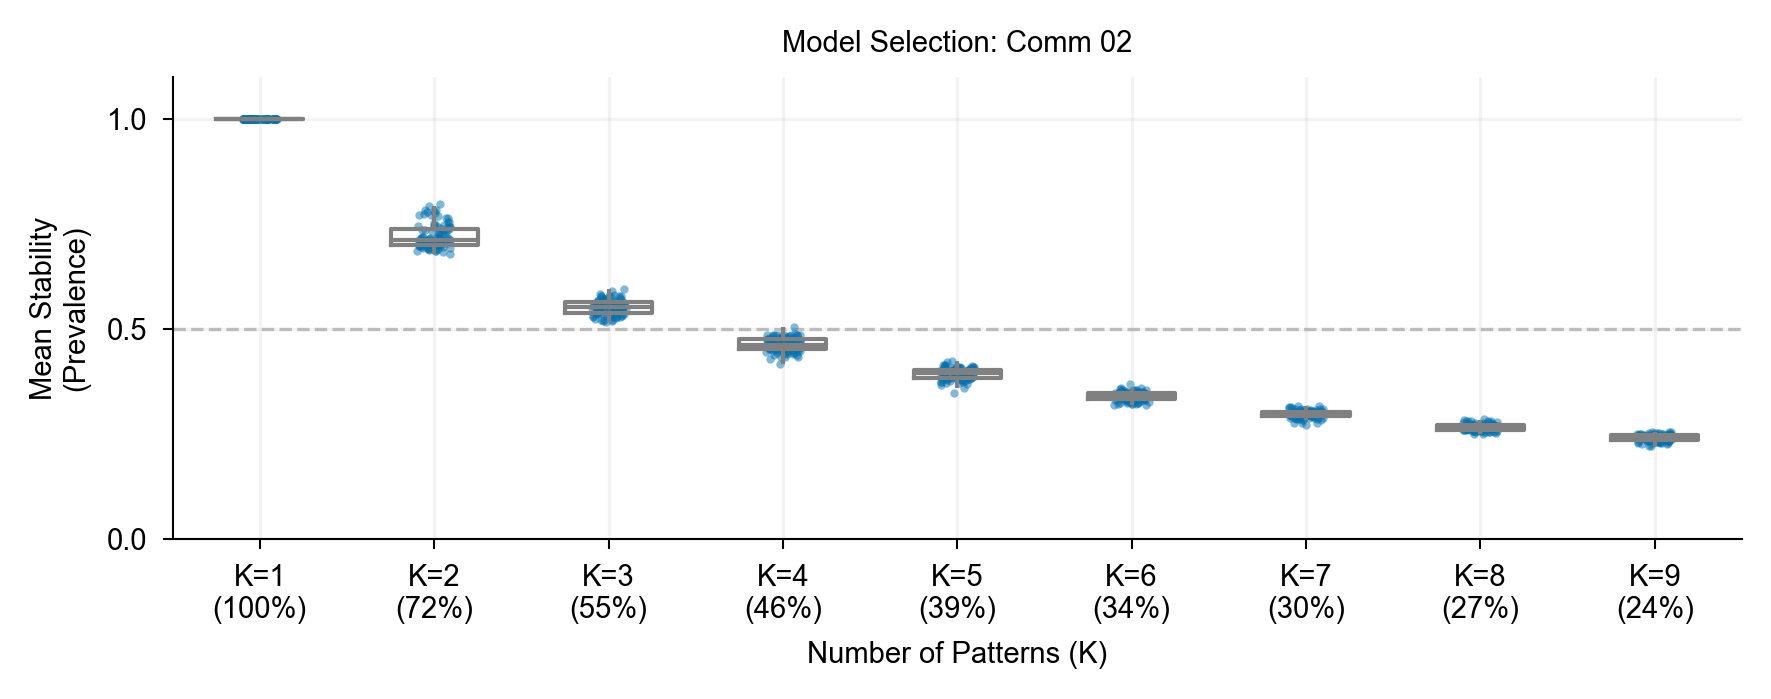

In [68]:
fig = plot_model_selection(df_boot, summary, comm)

We selected K=3 as the optimal model order, as it was the highest resolution that maintained a cross-sample generalizability >50%.

In [69]:
best_k = 3 #CODE THIS FROM SUMMARY

In [ ]:
best_gmm = GaussianMixture(
    n_components=best_k, 
    covariance_type='diag',
    n_init=20, 
    random_state=args.SEED,
).fit(community_vectors)
final_labels = best_gmm.predict(community_vectors)

medioid_vecs = get_medioids(
    best_k, final_labels, 
    best_gmm, community_vectors,
)

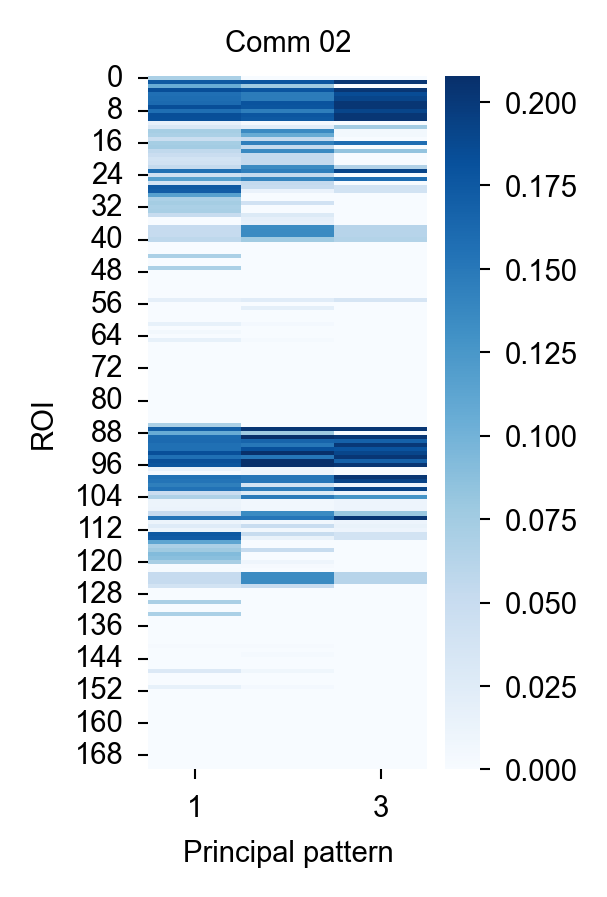

In [73]:
fig = plot_medioid_vectors(medioid_vecs, comm)